# Q-LearningAgent

In [1]:
import random
import numpy as np

#package for defining abstract base classes 
from abc import ABC, abstractmethod

class AbstractQLearningAgent(ABC):
    def __init__(self, env, epsilon_start, alpha, gamma):
        self.env = env
        self.epsilon = epsilon_start  # exploration constant
        self.alpha = alpha  # learning rate
        self.gamma = gamma  # discount factor
        self.actions = range(env.action_space.n) #actions

    @abstractmethod
    def get_q_value(self, state, action):
        raise Exception("Not Implemented")

    def choose_action(self, state):
        #epsilon-greedy policy 
        if random.random() < self.epsilon:
            action = random.choice(self.actions)
        else:
            q_values = [self.get_q_value(state, action) for action in self.actions]
            action = np.argmax(q_values)
        return action

    @abstractmethod
    def update(self, state, action, reward, next_state):
        raise Exception("Not Implemented")

## Tabular method with discretized states

In [2]:
class QLearningAgentTabular(AbstractQLearningAgent):

    def __init__(self, env, epsilon_start, alpha, gamma, discretisations=10):
        super().__init__(env, epsilon_start, alpha, gamma)
        self.q_table = {}
        self.discretisations = discretisations
    
    def _discretize(self, state):
        #returns the discrete_state?
        low = self.env.observation_space.low
        high = self.env.observation_space.high
        diff = (high - low) / self.discretisations
        discrete_state = (state - low) // diff
        return tuple(discrete_state.tolist())

    def get_q_value(self, state, action):
        discrete_state = self._discretize(state)
        if (discrete_state, action) not in self.q_table:
            return 0.0
        else:
            return self.q_table[(discrete_state, action)]

    def update(self, state, action, reward, next_state):
        #do one learning step
        discrete_state = self._discretize(state)
        q_value_old = self.q_table.get((discrete_state, action))
        q_value_new = reward + self.gamma * max([self.get_q_value(next_state, a) for a in self.actions])
        if q_value_old is None:
            self.q_table[(discrete_state, action)] = reward
        else:
            self.q_table[(discrete_state, action)] = q_value_old + self.alpha * (q_value_new - q_value_old)

## Linear Approximation 

In [3]:
class QLearningAgentApproximator(AbstractQLearningAgent):

    def __init__(self, env, epsilon, alpha, gamma, basis_functions_per_dimension=10):
        super().__init__(env, epsilon, alpha, gamma)

        low = env.observation_space.low
        high = env.observation_space.high

        xx, yy = np.meshgrid(np.linspace(low[0], high[0], basis_functions_per_dimension),
                             np.linspace(low[1], high[1], basis_functions_per_dimension))
        radials = np.append(xx.reshape(xx.shape + (1,)), yy.reshape(yy.shape + (1,)), axis=2)
        self.radials = radials.reshape((radials.size // 2, 2))        
        low = env.observation_space.low
        high = env.observation_space.high
        self.sigma_inv = 1 / (high  - low) * basis_functions_per_dimension

        self.weights = np.random.random((len(self.actions), basis_functions_per_dimension ** 2)) * 0.01 
        #shape of weights = (3, 100)
    
    def _feature_vector(self, state):
        r = self.sigma_inv * (self.radials - state)
        return np.exp(-0.5 * np.sum(r * r, axis=1))

    def get_q_value(self, state, action):
        x = self._feature_vector(state)
        return np.dot(np.transpose(x), self.weights[action])

    def update(self, state, action, reward, next_state):
        # do one learning step
        x = self._feature_vector(state)  #gradient!
        approx = self.get_q_value(state, action)
        target = reward + self.gamma * max([self.get_q_value(next_state, a) for a in self.actions])
        
        #Stochastic gradient descent
        self.weights[action]  += self.alpha * (target - approx)*x

# Main

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


<IPython.core.display.Javascript object>


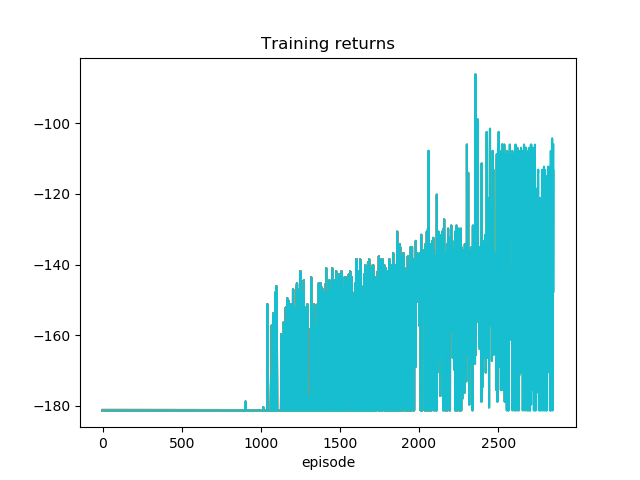

<IPython.core.display.Javascript object>


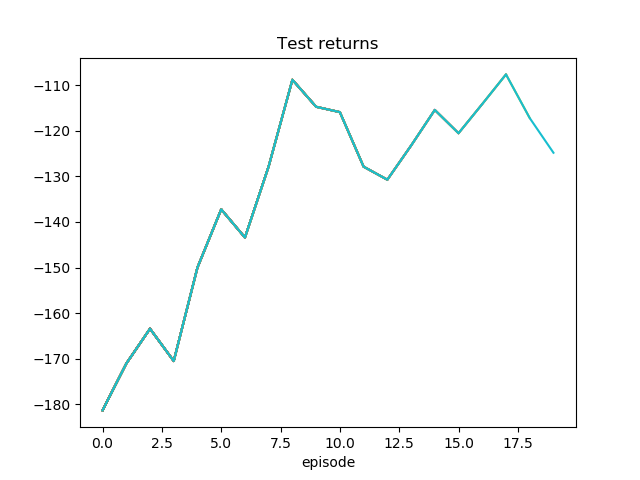

episode     0, return -181.35117052136442, epsilon 0.90
episode   150, return -181.35117052136442, epsilon 0.85
episode   300, return -181.35117052136442, epsilon 0.81
episode   450, return -181.35117052136442, epsilon 0.76
episode   600, return -181.35117052136442, epsilon 0.72
episode   750, return -181.35117052136442, epsilon 0.67
episode   900, return -181.35117052136442, epsilon 0.63
episode  1050, return -181.35117052136442, epsilon 0.58
episode  1200, return -181.35117052136442, epsilon 0.54
episode  1350, return -159.77625376121125, epsilon 0.49
episode  1500, return -151.32761854110967, epsilon 0.45
episode  1650, return -181.35117052136442, epsilon 0.40
episode  1800, return -147.07149678504584, epsilon 0.36
episode  1950, return -181.35117052136442, epsilon 0.31
episode  2100, return -145.3630775771225, epsilon 0.27
episode  2250, return -140.2172606996467, epsilon 0.22
episode  2400, return -156.4069397048638, epsilon 0.18
episode  2550, return -117.55828854422911, epsilon 

In [13]:
%matplotlib notebook

import gym
from mpl_toolkits.mplot3d import axes3d
from matplotlib import pyplot as plt
import numpy as np


def episode(env, agent, gamma, render=False):
    state = env.reset()
    discounted_return = 0
    done = False
    time_step = 0
    while not done:
        action = agent.choose_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.update(state, action, reward, next_state)
        if render:
            env.render()
        discounted_return += reward*(gamma**time_step)
        state = next_state
        time_step +=1
    return discounted_return


def train(env, agent, gamma, nr_episodes, epsilon_start, fig, ax, fig2, ax2):
    returns = []
    test_returns = []
    for i in range(nr_episodes):
        agent.epsilon = max(0.1, agent.epsilon - epsilon_start/nr_episodes)
        episode_return = episode(env, agent, gamma)
        
        returns.append(episode_return)
        if i % (nr_episodes//20) == 0:
            print("episode {:5d}, return {}, epsilon {:.2f}".format(i, episode_return, agent.epsilon))
            epsilon = agent.epsilon
            agent.epsilon = 0
            test_returns.append(sum([episode(env, agent, gamma) for _ in range(10)]) / 10.)
            agent.epsilon = epsilon
            ax.plot(returns)
            fig.canvas.draw()
            ax2.plot(test_returns)
            fig2.canvas.draw()
            

def plot_values(env, agent):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    low = env.observation_space.low
    high = env.observation_space.high
    xs = np.linspace(low[0], high[0], 500)
    ys = np.linspace(low[1], high[1], 500)
    X, Y = np.meshgrid(xs, ys)

    states = np.append(X.reshape(X.shape + (1,)), Y.reshape(Y.shape + (1,)), axis=2)
    states = states.reshape((states.shape[0]*states.shape[1], 2,))
    values = np.array(list(map(lambda x: max([agent.get_q_value(x, a) for a in agent.actions]), states))) #state value
    Z = -values.reshape(X.shape)

    # plot reward function (multiplied by -1)
    ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel("state value")
    plt.show()
  
    
env = gym.make('MountainCar-v0')
eps_start = 0.9
alpha = 0.01
gamma = 0.999
fig,ax = plt.subplots(1,1)
ax.set_title("Training returns")
ax.set_xlabel('episode')
fig2,ax2 = plt.subplots(1,1)
ax2.set_title("Test returns")
ax2.set_xlabel('episode')

#agent = QLearningAgentTabular(env, eps_start, alpha, gamma)
agent = QLearningAgentApproximator(env, eps_start, alpha, gamma)
nr_episodes = 3000

train(env, agent, gamma, nr_episodes, eps_start, fig, ax, fig2, ax2)

<IPython.core.display.Javascript object>


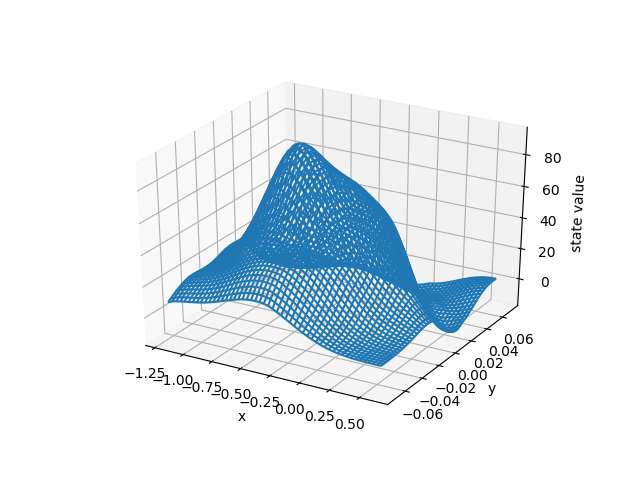

In [14]:
#Plot the state values
plot_values(env, agent)

In [7]:
#visualize learned policy within domain for 3 episodes
agent.epsilon = 0
for _ in range(3):
     episode(env, agent, render = True)